# Lab 5

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/giswqs/geog-312/blob/main/book/labs/lab_05.ipynb)

## Objective

This lab introduces you to essential GIS raster operations using Python's rasterio and matplotlib libraries. By the end of this lab, you will have learned to:

- Read and explore raster data files.
- Visualize and manipulate single-band and multi-band rasters.
- Perform basic raster operations such as clipping, band math, and reprojection.
- Work with Digital Elevation Models (DEMs) and multispectral satellite imagery.

## Required Libraries

Make sure you have the following libraries installed:

In [1]:
# %pip install rasterio matplotlib numpy

In [2]:
import rasterio
import rasterio.plot
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

## Sample Datasets

- Singlg-band image (DEM): https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif
- Multispectral image (Landsat): https://github.com/opengeos/datasets/releases/download/raster/cog.tif

## Exercise 1: Reading and Exploring Raster Data

1. Open the single-band DEM image using `rasterio`.
2. Retrieve and print the raster metadata, including the CRS, resolution, bounds, number of bands, and data types.
3. Display the raster’s width, height, and pixel data types to understand the grid dimensions and data structure.

In [3]:
sb = rasterio.open(
    "https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif"
)

In [4]:
sb.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 4269,
 'height': 3113,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]'),
 'transform': Affine(90.0, 0.0, -13442488.3428,
        0.0, -89.99579177642138, 4668371.5775)}

In [5]:
sb.width, sb.height

(4269, 3113)

In [6]:
sb.dtypes

('int16',)

## Exercise 2: Visualizing and Manipulating Raster Bands

1. Visualize the single-band DEM using a custom colormap (e.g., cmap='terrain').
2. Open the multispectral image and visualize the first band using a suitable colormap.
3. Combine multiple bands from the multispectral image (e.g., Red, Green, and Blue) and stack them to create an RGB composite image.

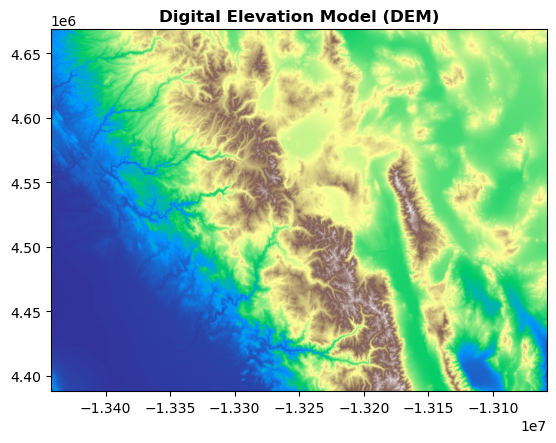

<Axes: title={'center': 'Digital Elevation Model (DEM)'}>

In [7]:
rasterio.plot.show(sb, cmap="terrain", title="Digital Elevation Model (DEM)")

In [8]:
mb = rasterio.open(
    "https://github.com/opengeos/datasets/releases/download/raster/cog.tif"
)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


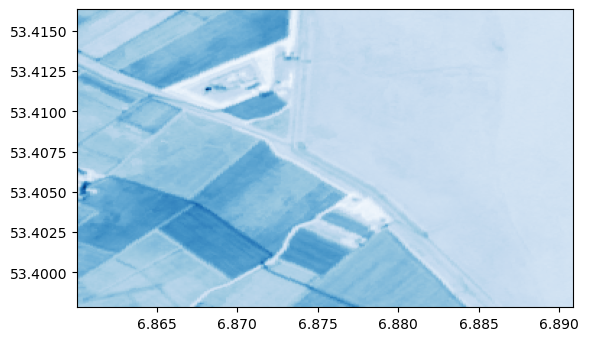

<Axes: >

In [9]:
rasterio.plot.show((mb, 2), cmap="Blues")

In [10]:
blue_band = mb.read(1)
red_band = mb.read(3)
green_band = mb.read(2)

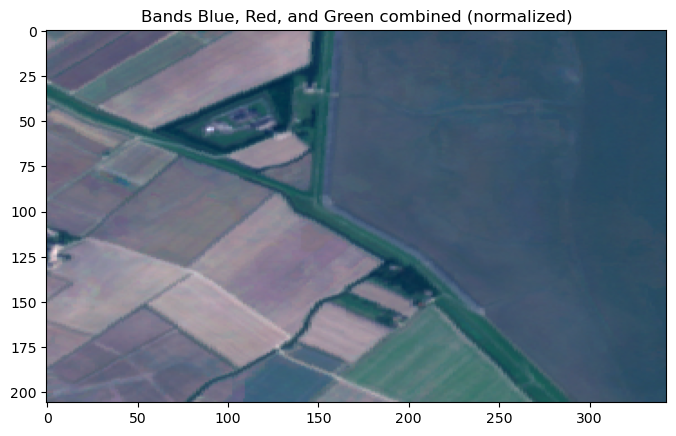

In [11]:
rgb = np.dstack((blue_band, green_band, red_band))

# Normalize the RGB array to 0–1 for display
rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())

# Plot the normalized stacked array
plt.figure(figsize=(8, 8))
plt.imshow(rgb_norm)
plt.title("Bands Blue, Red, and Green combined (normalized)")
plt.show()

## Exercise 3: Raster Clipping with Array Indexing

1. Open the multispectral image and clip a geographic subset using array indexing (specifying row and column ranges).
2. Visualize the clipped portion of the image using matplotlib to ensure the subset is correct.
3. Save the clipped raster subset to a new file named `clipped_multispectral.tif`.

In [12]:
mb = rasterio.open(
    "https://github.com/opengeos/datasets/releases/download/raster/cog.tif"
)
data = mb.read()
data.shape

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


(4, 206, 343)

In [13]:
subset = data[:, 100:200, 200:340]
rgb_subset = np.dstack((subset[3], subset[2], subset[1]))
rgb_subset.shape

(100, 140, 3)

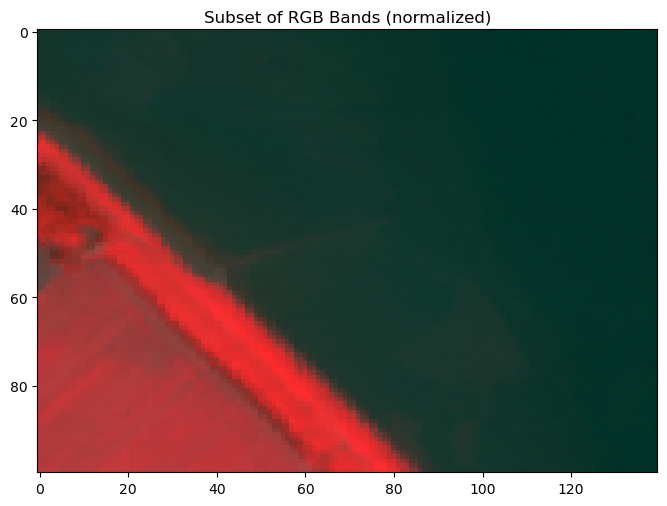

In [14]:
subset_norm = (rgb_subset - rgb_subset.min()) / (rgb_subset.max() - rgb_subset.min())
plt.figure(figsize=(8, 8))
plt.imshow(subset_norm)
plt.title("Subset of RGB Bands (normalized)")
plt.show()

In [15]:
with rasterio.open(
    "https://github.com/opengeos/datasets/releases/download/raster/cog.tif"
) as src:
    profile = src.profile

In [16]:
from rasterio.windows import Window
from rasterio.transform import from_bounds

# Assuming subset and src are already defined
# Define the window of the subset (replace with actual window coordinates)
window = Window(col_off=200, row_off=100, width=140, height=100)

# Calculate the bounds of the window
window_bounds = rasterio.windows.bounds(window, src.transform)

# Calculate the new transform based on the window bounds
new_transform = from_bounds(*window_bounds, window.width, window.height)

In [18]:
with rasterio.open(
    "output_file/lab5/clipped_multispectral.tif",
    "w",
    driver="GTiff",
    height=subset.shape[1],
    width=subset.shape[2],
    count=subset.shape[0],
    dtype=subset.dtype,
    crs=src.crs,
    transform=new_transform,
    compress="lzw",
) as dst:
    dst.write(subset)

## Exercise 4: Calculating NDWI (Band Math)

1. Open the multispectral image and extract the Green and Near-Infrared (NIR) bands. This multispectral image has the following band order:
   - Band 2: Blue
   - Band 3: Green
   - Band 4: Red
   - Band 5: NIR
2. Compute the Normalized Difference Water Index ([NDWI](https://en.wikipedia.org/wiki/Normalized_difference_water_index)) using the formula:

    NDWI= (Green - NIR) / (Green + NIR)

3. Visualize the NDWI result using a water-friendly colormap (e.g., cmap='Blues') to highlight water bodies.
4. Save the resulting NDWI image as a new raster file named ndwi.tif.

In [19]:
nir_band = mb.read(4)

In [20]:
ndvi = (nir_band - red_band) / (nir_band + red_band)
ndvi = ndvi.clip(-1, 1)

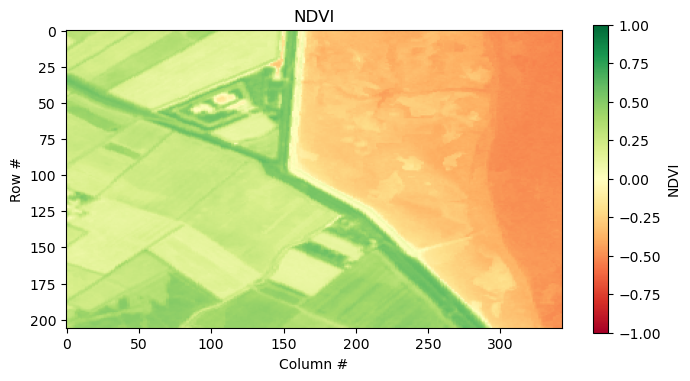

In [21]:
plt.figure(figsize=(8, 8))
plt.imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
plt.colorbar(label="NDVI", shrink=0.5)
plt.title("NDVI")
plt.xlabel("Column #")
plt.ylabel("Row #")
plt.show()

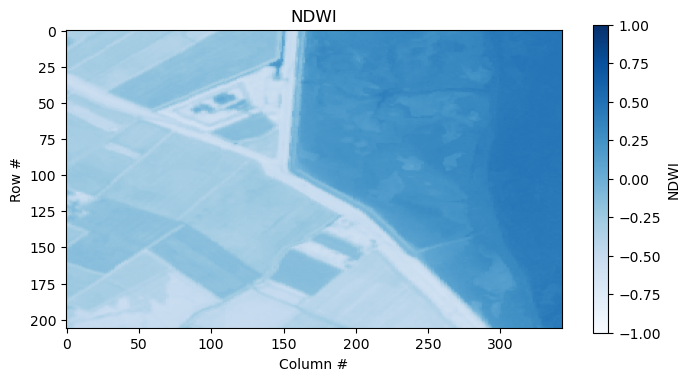

In [22]:
ndwi = (green_band - nir_band) / (green_band + nir_band)
ndwi = ndwi.clip(-1, 1)
plt.figure(figsize=(8, 8))
plt.imshow(ndwi, cmap="Blues", vmin=-1, vmax=1)
plt.colorbar(label="NDWI", shrink=0.5)
plt.title("NDWI")
plt.xlabel("Column #")
plt.ylabel("Row #")
plt.show()

In [23]:
profile.update(count=1)
print(profile)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 343, 'height': 206, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(8.983152841195215e-05, 0.0, 6.860074498707138,
       0.0, -8.983152841195215e-05, 53.41634207654228), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}


In [24]:
output_path = "ndwi.tif"
with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(ndwi, 1)
print(f"NDWI saved to {output_path}")

NDWI saved to ndwi.tif


## Exercise 5: Reprojecting Raster Data

1. Reproject the single-band DEM raster from its original CRS to EPSG:4326 (WGS 84) using the `rasterio.warp.reproject` function.
2. Save the reprojected raster to a new GeoTIFF file named `reprojected_dem.tif`.
3. Visualize both the original and reprojected DEM datasets to compare how the reprojection affects the spatial coverage and resolution.